# Лабораторна робота №4 з Обробĸи та аналізу теĸстових даних на Python.
# ІП-13 Ал Хадам Мурат. Варіант 1.

Створити програму, яка зчитує заданий набір даних, виконує попередню обробку та класифікацію документів відповідно до варіанту. Якщо недостатньо ресурсів для роботи з повним набором даних, можна виділити частину, але таким чином, щоб були присутні усі класи.

В якості текстової моделі використати TF-IDF. Виконати класифікацію за допомогою алгоритмів наївний байєсів  класифікатор та опорні вектори, порівняти їх точність. Спробувати покращити моделі за допомогою  GridSearchCV.


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV

Завантажуємо дані та розбиваємо на X та Y

In [2]:
data = pd.read_csv('bbc-news-data.csv', delimiter='\t')
data

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...,...
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...


Розбиваємо дані залежні/незалежні змінні

In [3]:
X = data['content']
y = data['category']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
X_train_bow = tfidf_vectorizer.fit_transform(X_train)
X_test_bow = tfidf_vectorizer.transform(X_test)

In [6]:
X_test_bow = X_test_bow.toarray()

In [7]:
X_train_bow = X_train_bow.toarray()

Виконати класифікацію за допомогою алгоритмів наївний байєсів  класифікатор та опорні вектори, порівняти їх точність. Спробувати покращити моделі за допомогою  GridSearchCV.

MultinomialNB

In [8]:
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb_parameters = {
    'alpha': [0.1, 0.5, 1, 5]
}

mnb_grid_search = GridSearchCV(mnb, mnb_parameters, cv=5, scoring='accuracy')
mnb_grid_search.fit(X_train_bow, y_train)

print("Best value for 'alpha' hyperparameter is", mnb_grid_search.best_params_['alpha'])

Best value for 'alpha' hyperparameter is 0.1


In [9]:
from sklearn.metrics import accuracy_score

mnb_best_model = mnb_grid_search.best_estimator_
mnb_best_test_pred = mnb_best_model.predict(X_test_bow)

print('Accuracy for mnb best model is: ', accuracy_score(y_test, mnb_best_test_pred))

Accuracy for mnb best model is:  0.9707865168539326


LinearSVC

In [10]:
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings('ignore')

svc = LinearSVC()
svc_parameters = {
    'C': [0.1, 1, 10],
    'max_iter': [i * 1000 for i in range(5)]
}

svc_grid_search = GridSearchCV(svc, svc_parameters, cv=5, scoring='accuracy')
svc_grid_search.fit(X_train_bow, y_train)

print("Best value for 'C' hyperparameter is", svc_grid_search.best_params_['C'])
print("Best value for 'max_iter' hyperparameter is", svc_grid_search.best_params_['max_iter'])

Best value for 'C' hyperparameter is 1
Best value for 'max_iter' hyperparameter is 1000


In [11]:
svc_best_model = svc_grid_search.best_estimator_
svc_best_test_pred = svc_best_model.predict(X_test_bow)

print('Accuracy for svc best model is: ', accuracy_score(y_test, svc_best_test_pred))

Accuracy for svc best model is:  0.9730337078651685


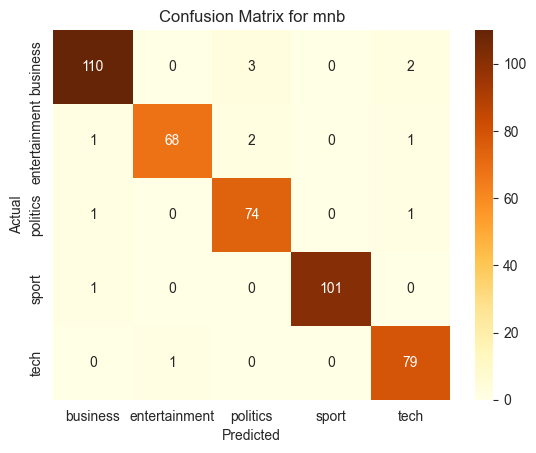

Classification report for mnb:
               precision    recall  f1-score   support

     business       0.97      0.96      0.96       115
entertainment       0.99      0.94      0.96        72
     politics       0.94      0.97      0.95        76
        sport       1.00      0.99      1.00       102
         tech       0.95      0.99      0.97        80

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445


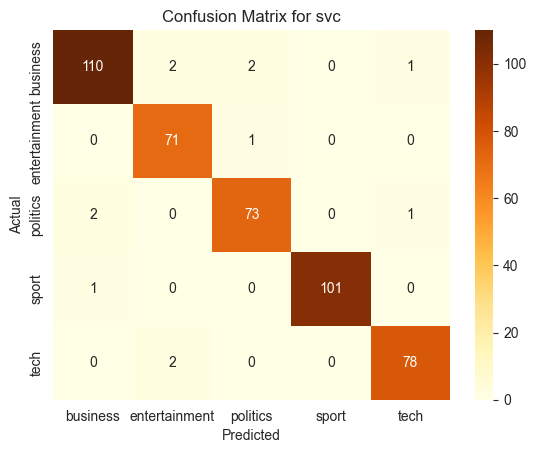

Classification report for svc:
               precision    recall  f1-score   support

     business       0.97      0.96      0.96       115
entertainment       0.95      0.99      0.97        72
     politics       0.96      0.96      0.96        76
        sport       1.00      0.99      1.00       102
         tech       0.97      0.97      0.97        80

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445


In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

models = [mnb_best_model, svc_best_model]
names = ['mnb', 'svc']
class_labels = ['business', 'entertainment', 'politics', 'sport', 'tech']

for model, name in zip(models, names):
    confusion = confusion_matrix(y_true=y_test, y_pred=model.predict(X_test_bow))
    confusion_df = pd.DataFrame(confusion, index=class_labels, columns=class_labels)
    sns.heatmap(confusion_df, annot=True, fmt='d', cmap='YlOrBr')

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    report = classification_report(y_test, model.predict(X_test_bow))
    print(f'Classification report for {name}:', report, sep='\n')